### Logic

1. Load data
2. Prepare features and label datasets for the Gradient Boost models
    - Add default notice and rescind counts to training data
    - Remove columns water, sewer, heating_fuel_type, style due to low row count
3. Build a Gradient Boost regression model to estimate lien_amount
    - Note:  The purpose of this estimate is for calculating risk (weighted by lien amount).  Eventhough the accuracy is very poor, this measure is the best proxy available for applying lien amount weight for calculating risk.
4. Build a Gradient Boost classification model to estimate probability of underwriting insurance with potential lien liability

In [26]:
import numpy as np
import pandas as pd

#import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

import matplotlib.pyplot as plt
from matplotlib import pyplot 

%matplotlib inline

### 1. Load Data

In [27]:
# Load data

train_property_data = pd.read_csv("train_property_data.csv")
test_property_data = pd.read_csv("test_property_data.csv")
default_notices = pd.read_csv("default_notices.csv")

In [50]:
# Print row count of property data
print (train_property_data.count())

house_id               40000
state                  40000
zipcode                40000
county_fips            39983
total_bath_count       36588
year_built             38793
building_area_sq_ft    39398
property_type          39398
exterior_walls         24532
water                   8668
sewer                   8228
heating                31218
heating_fuel_type       8378
fireplace              39398
style                   4512
garage_type_parking    31171
title_check_date       40000
lien_amount            40000
dtype: int64


In [51]:
# Print row count of default notices data
print (default_notices.count())

house_id       148450
record_date    148450
event_type     148444
dtype: int64


In [54]:
default_notices[5:10]

,house_id,record_date,event_type
5,13577,2013-01-28,default_rescind
6,165237,2014-07-23,default_notice
7,13580,2011-12-21,default_notice
8,13580,2012-06-06,default_rescind
9,13580,2016-06-21,default_notice


### 2. Prepare features and label datasets for the Gradient Boost  models

In [4]:
#
# Prepare features for the Gradient Boost models
# 1. Include frequency of default notices into training data
#    default_notice: count of default notice
#    default_rescind: count of default rescind
# 2. Remove columns exterior_walls, water, sewer, heating_fuel_type, style due to low row count
#
def prepare_features (property_data, default_data):
    df = property_data.set_index('house_id').join(
        default_data.set_index('house_id'), how='left', on='house_id').reset_index()
    #x = x.loc[x['title_check_date'] >= x['record_date'], :]
    df = df[['house_id','event_type']].groupby(['house_id','event_type']).size().reset_index()
    df = pd.DataFrame(df)
    df.columns = ['house_id', 'event_type', 'count']
    df = df.pivot(index='house_id', columns='event_type', values='count').reset_index().fillna(0)
    df['default_net'] = df['default_notice'] - df['default_rescind']
    df = property_data.set_index('house_id').join(df.set_index('house_id'), how='left', on='house_id').reset_index()
    df['zipcode'] = df.zipcode.astype(str)
    df['county_fips'] = df.county_fips.astype(str)
    df['default_notice'] = df['default_notice'].apply(lambda x: 1 if x > 0 else 0)
    df = df[['house_id', 'state', 'zipcode', 'county_fips', 'total_bath_count', 'year_built',
           'building_area_sq_ft', 'property_type', 'fireplace', 'garage_type_parking', 
           'default_notice', 'default_rescind', 'default_net', 'lien_amount']]
    
    df = pd.get_dummies(df)
    return df

def prepare_features_for_scoring (property_data, default_data):
    df = property_data.set_index('house_id').join(
        default_data.set_index('house_id'), how='left', on='house_id').reset_index()
    #x = x.loc[x['title_check_date'] >= x['record_date'], :]
    df = df[['house_id','event_type']].groupby(['house_id','event_type']).size().reset_index()
    df = pd.DataFrame(df)
    df.columns = ['house_id', 'event_type', 'count']
    df = df.pivot(index='house_id', columns='event_type', values='count').reset_index().fillna(0)
    df['default_net'] = df['default_notice'] - df['default_rescind']
    df = property_data.set_index('house_id').join(df.set_index('house_id'), how='left', on='house_id').reset_index()
    df['zipcode'] = df.zipcode.astype(str)
    df['county_fips'] = df.county_fips.astype(str)
    df['default_notice'] = df['default_notice'].apply(lambda x: 1 if x > 0 else 0)
    df = df[['house_id', 'state', 'zipcode', 'county_fips', 'total_bath_count', 'year_built',
           'building_area_sq_ft', 'property_type', 'fireplace', 'garage_type_parking', 
           'default_notice', 'default_rescind', 'default_net']]
    
    df = pd.get_dummies(df)
    return df

In [5]:
#
# Prepare training and validation data
#
# X_train, X_test: features
# y_train, y_test: target for Gradient Boost regression model
# yc_train, yc_test: target for Gradient Boost classification model
#
#

data = prepare_features (train_property_data, default_notices)
#data = (data[~np.isnan(data).any(axis=1)])
X = data.drop(columns=['house_id', 'lien_amount'])

#from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler(feature_range=(0, 1))
#X = scaler.fit_transform(X)

y = data['lien_amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

yc_train = y_train.apply(lambda x: 1 if x > 0 else 0)
yc_test = y_test.apply(lambda x: 1 if x > 0 else 0)

### 3. Build a Gradient Boost Regression model to estimate lien_amount (for risk calculation purpose only)

In [6]:
# This needs to be changed to use means

X_train = X_train.fillna(0)
y_train = y_train.fillna(0)

X_test = X_test.fillna(0)
y_test = y_test.fillna(0)


'''
fix the following code...
#Obtain mean of columns as you need, nanmean is just convenient.
col_mean = np.nanmean(X_train, axis=0)

#Find indicies that you need to replace
inds = np.where(np.isnan(X_train))

#Place column means in the indices. Align the arrays using take
X_train[inds] = np.take(col_mean, inds[1])
'''

'\nfix the following code...\n#Obtain mean of columns as you need, nanmean is just convenient.\ncol_mean = np.nanmean(X_train, axis=0)\n\n#Find indicies that you need to replace\ninds = np.where(np.isnan(X_train))\n\n#Place column means in the indices. Align the arrays using take\nX_train[inds] = np.take(col_mean, inds[1])\n'

In [7]:
# import machine learning algorithms
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

In [8]:
# Define model
gb_reg = GradientBoostingRegressor(learning_rate = 0.01,
                                   n_estimators = 100,
                                   subsample=1.0,
                                   max_depth = 4,
                                   max_features = 0.3,
                                   alpha = 0.3
                                   )

In [9]:
# Fit model (train)
%time gb_reg.fit(X_train, y_train)

CPU times: user 35.2 s, sys: 631 ms, total: 35.8 s
Wall time: 35.6 s


GradientBoostingRegressor(alpha=0.3, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=4, max_features=0.3,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [10]:
gb_reg.score(X_test, y_test)

-0.01023317031235016

In [11]:
# Calculate Training and Test MSEs

%time preds = gb_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("Test RMSE: %f" % (rmse))

%time preds = gb_reg.predict(X_train)
rmse = np.sqrt(mean_squared_error(y_train, preds))
print("Training RMSE: %f" % (rmse))

CPU times: user 220 ms, sys: 10 ms, total: 230 ms
Wall time: 229 ms
Test RMSE: 12041.004617
CPU times: user 963 ms, sys: 261 ms, total: 1.22 s
Wall time: 1.22 s
Training RMSE: 10917.141498


In [12]:
# List top 10 important features

top10args = gb_reg.feature_importances_.argsort()[-10:][::-1]
print(*X_train.columns.values[top10args], sep="\n")

building_area_sq_ft
total_bath_count
year_built
zipcode_30305
default_net
zipcode_85022
zipcode_32814
zipcode_85016
default_rescind
zipcode_98011


### 4. Build a Gradient Boost Classification model to estimate probability of underwriting insurance with potential default

##### ignore .... used for tuning...  ended up not using it...
weight_ratio = float(len(yc_train[yc_train == 0]))/float(len(yc_train[yc_train == 
1]))

weight_ratio=1
w_array = np.array([1]*yc_train.shape[0])
w_array[yc_train==1] = weight_ratio
w_array[yc_train==0] = 1


In [13]:
gb_cls = GradientBoostingClassifier(learning_rate=0.1, 
                                    n_estimators=500,
                                    max_depth=4)

'''
gb_cls = GradientBoostingClassifier(n_estimators=20, 
                                    learning_rate = 0.5, 
                                    max_features=2, 
                                    max_depth = 2, 
                                    random_state = 0)
'''

'\ngb_cls = GradientBoostingClassifier(n_estimators=20, \n                                    learning_rate = 0.5, \n                                    max_features=2, \n                                    max_depth = 2, \n                                    random_state = 0)\n'

In [14]:
# Fit the model - takes ~7.5min

%time gb_cls.fit(X_train, yc_train)

CPU times: user 7min 24s, sys: 1.5 s, total: 7min 26s
Wall time: 7min 26s


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

Confusion Matrix:
[[7120   69]
 [ 727   84]]

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      7189
           1       0.55      0.10      0.17       811

   micro avg       0.90      0.90      0.90      8000
   macro avg       0.73      0.55      0.56      8000
weighted avg       0.87      0.90      0.87      8000



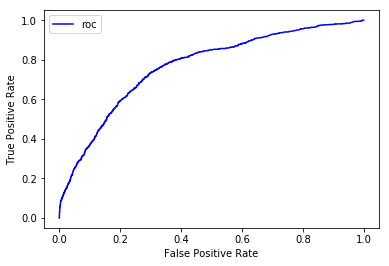

Area under ROC curve = 0.77


In [15]:
# Calculate Confusion Matrix, Precision measures, ROC curve and Area-Under-Curve (AUC)

predictions = gb_cls.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(yc_test, predictions))
print()
print("Classification Report")
print(classification_report(yc_test, predictions))

# ROC curve and Area-Under-Curve (AUC)

y_scores_gb = gb_cls.decision_function(X_test)
fpr_gb, tpr_gb, _ = roc_curve(yc_test, y_scores_gb)
roc_auc_gb = auc(fpr_gb, tpr_gb)

plt.plot(fpr_gb, tpr_gb, color='blue', label="roc")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

print("Area under ROC curve = {:0.2f}".format(roc_auc_gb))

#### Note:
The AUC and overall accuracies are important.  The class level accuracies will be readjusted in the risk model below. 